In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import seaborn as sns
import time
import random
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers.experimental import Adamax
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import Lion
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Instal Split Folder

In [2]:
!pip install split-folders

# Inisiasi Directory Untuk Input(Dataset) dan Output 

In [3]:
folder_path = f"run/"
os.makedirs(folder_path, exist_ok=True)

# Folder dataset disimpan
dataset_input = r"/kaggle/input/lymphoma/lymphoma"
dataset_output = r"/kaggle/working/run"

In [4]:
import splitfolders
splitfolders.ratio(dataset_input, dataset_output, seed=42, ratio=(.7, .15, .15))

Copying files: 374 files [00:18, 19.93 files/s]


# Load Gambar

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import time
import numpy as np

# Dimensi gambar
img_height, img_width = 1338, 1040  # EfficientNetV2-B0 expects input size 224x224
dimension = (img_height, img_width)
batch_size = 8

# Direktori data
train_data_dir = r"/kaggle/working/run/train"
valid_data_dir = r"/kaggle/working/run/val"
test_data_dir = r"/kaggle/working/run/test"

# Augmentasi data untuk pelatihan
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Use EfficientNetV2 preprocess_input
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

# Memuat data pelatihan
train_data = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=dimension,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Memuat data validasi
valid_data = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=dimension,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Memuat data uji
test_data = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=dimension,
    batch_size=1,  # Batch size 1 untuk evaluasi
    class_mode='categorical'
)

# Strategi distribusi untuk multiple GPUs
strategy = tf.distribute.MirroredStrategy()

# Membangun model di dalam strategi
with strategy.scope():
    # Gunakan EfficientNetV2-B0 sebagai base model
    base_model = EfficientNetV2L(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Pelatihan model
    start = time.time()
    summary = model.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, batch_size=batch_size)
    end = time.time()
    elapsed_time = end - start
    print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

    # Evaluasi pada data uji
    test_loss, test_acc = model.evaluate(test_data, verbose=1)
    print('\nTest accuracy: ', test_acc)

    # Evaluasi pada data pelatihan
    validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
    print('\nTraining accuracy: ', validation_acc)

    # Evaluasi pada data validasi
    validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
    print('\nValidation accuracy: ', validation_acc)

    # Prediksi pada data uji
    y_pred = model.predict(test_data)
    y_true = test_data.classes
    y_pred = np.argmax(y_pred, axis=1)

    # Laporan klasifikasi
    classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
    print(classification_rep)

Found 158 images belonging to 3 classes.
Found 103 images belonging to 3 classes.
Found 59 images belonging to 3 classes.
473176280/473176280 [==============================] - 3s 0us/step
Epoch 1/100


2024-01-06 16:21:12.839168: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 202s 7s/step - loss: 1.1464 - accuracy: 0.4810 - val_loss: 1.2455 - val_accuracy: 0.3592
Epoch 2/100
20/20 [==============================] - 117s 6s/step - loss: 0.8075 - accuracy: 0.6329 - val_loss: 1.2433 - val_accuracy: 0.3981
Epoch 3/100
20/20 [==============================] - 117s 6s/step - loss: 0.6167 - accuracy: 0.7215 - val_loss: 1.5488 - val_accuracy: 0.3204
Epoch 4/100
20/20 [==============================] - 113s 6s/step - loss: 0.6101 - accuracy: 0.7152 - val_loss: 1.5306 - val_accuracy: 0.3204
Epoch 5/100
20/20 [==============================] - 115s 6s/step - loss: 0.5594 - accuracy: 0.7785 - val_loss: 1.6945 - val_accuracy: 0.3010
Epoch 6/100
20/20 [==============================] - 116s 6s/step - loss: 0.4033 - accuracy: 0.8481 - val_loss: 1.8782 - val_accuracy: 0.3301
Epoch 7/100
20/20 [==============================] - 115s 6s/step - loss: 0.4907 - accuracy: 0.7722 - val_loss: 2.0850 - val_accuracy: 0.3689
Epoch 8/100
20/20 

In [6]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.applications import EfficientNetV2S
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report
# import time
# import numpy as np

# # Dimensi gambar
# img_height, img_width = 1338, 1040  # EfficientNetV2-B0 expects input size 224x224
# dimension = (img_height, img_width)
# batch_size = 8

# # Direktori data
# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# # Augmentasi data untuk pelatihan
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Use EfficientNetV2 preprocess_input
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Memuat data pelatihan
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# # Memuat data validasi
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Memuat data uji
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,  # Batch size 1 untuk evaluasi
#     class_mode='categorical'
# )

# # Strategi distribusi untuk multiple GPUs
# strategy = tf.distribute.MirroredStrategy()

# # Membangun model di dalam strategi
# with strategy.scope():
#     # Gunakan EfficientNetV2-B0 sebagai base model
#     base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#     # Pelatihan model
#     start = time.time()
#     summary = model.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, batch_size=batch_size)
#     end = time.time()
#     elapsed_time = end - start
#     print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

#     # Evaluasi pada data uji
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     # Evaluasi pada data pelatihan
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTraining accuracy: ', validation_acc)

#     # Evaluasi pada data validasi
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValidation accuracy: ', validation_acc)

#     # Prediksi pada data uji
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     # Laporan klasifikasi
#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [7]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.applications import EfficientNetV2B3  # Import EfficientNetV2B0
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report
# import time
# import numpy as np

# # Dimensi gambar
# img_height, img_width = 1338, 1040  # EfficientNetV2-B0 expects input size 224x224
# dimension = (img_height, img_width)
# batch_size = 8

# # Direktori data
# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# # Augmentasi data untuk pelatihan
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Use EfficientNetV2 preprocess_input
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Memuat data pelatihan
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# # Memuat data validasi
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Memuat data uji
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,  # Batch size 1 untuk evaluasi
#     class_mode='categorical'
# )

# # Strategi distribusi untuk multiple GPUs
# strategy = tf.distribute.MirroredStrategy()

# # Membangun model di dalam strategi
# with strategy.scope():
#     # Gunakan EfficientNetV2-B0 sebagai base model
#     base_model = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#     # Pelatihan model
#     start = time.time()
#     summary = model.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, batch_size=batch_size)
#     end = time.time()
#     elapsed_time = end - start
#     print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

#     # Evaluasi pada data uji
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     # Evaluasi pada data pelatihan
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTraining accuracy: ', validation_acc)

#     # Evaluasi pada data validasi
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValidation accuracy: ', validation_acc)

#     # Prediksi pada data uji
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     # Laporan klasifikasi
#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [8]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.applications import DenseNet169
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report
# import time
# import numpy as np

# # Dimensi gambar
# img_height, img_width = 331, 331  # Ganti sesuai kebutuhan Anda
# dimension = (img_height, img_width)
# batch_size = 8

# # Direktori data
# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# # Augmentasi data untuk pelatihan
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.densenet.preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Memuat data pelatihan
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# # Memuat data validasi
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Memuat data uji
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,  # Batch size 1 untuk evaluasi
#     class_mode='categorical'
# )

# # Strategi distribusi untuk multiple GPUs
# strategy = tf.distribute.MirroredStrategy()

# # Membangun model di dalam strategi
# with strategy.scope():
#     # Gunakan ukuran input yang benar untuk DenseNet169
#     base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#     # Pelatihan model
#     start = time.time()
#     summary = model.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, batch_size=batch_size)
#     end = time.time()
#     elapsed_time = end - start
#     print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

#     # Evaluasi pada data uji
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     # Evaluasi pada data pelatihan
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTraining accuracy: ', validation_acc)

#     # Evaluasi pada data validasi
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValidation accuracy: ', validation_acc)

#     # Prediksi pada data uji
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     # Laporan klasifikasi
#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)


In [9]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.applications import EfficientNetB7
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report
# import time
# import numpy as np

# # Dimensi gambar
# img_height, img_width = 1338, 1040
# dimension = (img_height, img_width)
# batch_size = 8

# # Direktori data
# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# # Augmentasi data untuk pelatihan
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Memuat data pelatihan
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# # Memuat data validasi
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Memuat data uji
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,  # Batch size 1 untuk evaluasi
#     class_mode='categorical'
# )

# # Strategi distribusi untuk multiple GPUs
# strategy = tf.distribute.MirroredStrategy()

# # Membangun model di dalam strategi
# with strategy.scope():
#     # Gunakan ukuran input yang benar untuk EfficientNetB2
#     base_model = EfficientNetB7(include_top=False, weights='imagenet')
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs = base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#       layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics = ['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=100,validation_data=valid_data, verbose = 1,batch_size=8)
#     end = time.time()
#     elapsed_time = end - start
#     print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

#     # Evaluasi pada data uji
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     # Evaluasi pada data pelatihan
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTraining accuracy: ', validation_acc)

#     # Evaluasi pada data validasi
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValidation accuracy: ', validation_acc)

#     # Prediksi pada data uji
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     # Laporan klasifikasi
#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [10]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report
# import time
# import numpy as np

# # Dimensi gambar
# img_height, img_width = 1338, 1040
# dimension = (img_height, img_width)
# batch_size = 8

# # Direktori data
# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# # Augmentasi data untuk pelatihan
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Memuat data pelatihan
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# # Memuat data validasi
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Memuat data uji
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,  # Batch size 1 untuk evaluasi
#     class_mode='categorical'
# )

# # Strategi distribusi untuk multiple GPUs
# strategy = tf.distribute.MirroredStrategy()

# # Membangun model di dalam strategi
# with strategy.scope():
#     # Gunakan ukuran input yang benar untuk EfficientNetB2
#     base_model = EfficientNetB3(include_top=False, weights='imagenet')
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs = base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#       layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics = ['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=100,validation_data=valid_data, verbose = 1,batch_size=8)
#     end = time.time()
#     elapsed_time = end - start
#     print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

#     # Evaluasi pada data uji
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     # Evaluasi pada data pelatihan
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTraining accuracy: ', validation_acc)

#     # Evaluasi pada data validasi
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValidation accuracy: ', validation_acc)

#     # Prediksi pada data uji
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     # Laporan klasifikasi
#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [11]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report
# import time
# import numpy as np

# # Dimensi gambar
# img_height, img_width = 1338, 1040
# dimension = (img_height, img_width)
# batch_size = 8

# # Direktori data
# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# # Augmentasi data untuk pelatihan
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Memuat data pelatihan
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# # Memuat data validasi
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Memuat data uji
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,  # Batch size 1 untuk evaluasi
#     class_mode='categorical'
# )

# # Strategi distribusi untuk multiple GPUs
# strategy = tf.distribute.MirroredStrategy()

# # Membangun model di dalam strategi
# with strategy.scope():
#     # Gunakan ukuran input yang benar untuk EfficientNetB2
#     base_model = EfficientNetB2(include_top=False, weights='imagenet')
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs = base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#       layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics = ['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=100,validation_data=valid_data, verbose = 1,batch_size=8)
#     end = time.time()
#     elapsed_time = end - start
#     print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

#     # Evaluasi pada data uji
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     # Evaluasi pada data pelatihan
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTraining accuracy: ', validation_acc)

#     # Evaluasi pada data validasi
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValidation accuracy: ', validation_acc)

#     # Prediksi pada data uji
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     # Laporan klasifikasi
#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [12]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.applications import NASNetLarge
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report
# import time
# import numpy as np

# # Dimensi gambar
# img_height, img_width = 331, 331
# dimension = (img_height, img_width)
# batch_size = 8

# # Direktori data
# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# # Augmentasi data untuk pelatihan
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.nasnet.preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Memuat data pelatihan
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# # Memuat data validasi
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Memuat data uji
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,  # Batch size 1 untuk evaluasi
#     class_mode='categorical'
# )

# # Strategi distribusi untuk multiple GPUs
# strategy = tf.distribute.MirroredStrategy()

# # Membangun model di dalam strategi
# with strategy.scope():
#     # Use the correct input size for NASNetLarge
#     input_tensor = Input(shape=(img_height, img_width, 3))
#     base_model = NASNetLarge(include_top=False, weights='imagenet', input_tensor=input_tensor)
    
#     # Tambahkan GlobalAveragePooling2D di dalam model
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)

#     model = Model(inputs=input_tensor, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#     # Pelatihan model
#     start = time.time()
#     summary = model.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, batch_size=batch_size)
#     end = time.time()
#     elapsed_time = end - start
#     print(f"Waktu Pelatihan: {elapsed_time:.2f} detik ({elapsed_time / 60:.2f} menit)")

#     # Evaluasi pada data uji
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     # Evaluasi pada data pelatihan
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTraining accuracy: ', validation_acc)

#     # Evaluasi pada data validasi
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValidation accuracy: ', validation_acc)

#     # Prediksi pada data uji
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     # Laporan klasifikasi
#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [13]:
# img_height, img_width = 1388, 1040
# dimension = (224, 224)
# dimension = (img_height, img_width)
# dimension = (331, 331)
# batch_size = 8




# train_data_dir = r"/kaggle/working/run/train"
# valid_data_dir = r"/kaggle/working/run/val"
# test_data_dir = r"/kaggle/working/run/test"

# Pre- Processing

In [14]:
# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size = dimension,
#     batch_size = 8,
#     class_mode = 'categorical',

# )

# valid_data = train_datagen.flow_from_directory(
#     valid_data_dir,
#     target_size = dimension,
#     batch_size = 8,
#     class_mode = 'categorical',

# )
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size = dimension,
#     batch_size = 1,
#     class_mode = 'categorical'
# )

In [15]:
# train_datagen = ImageDataGenerator(
# #     preprocessing_function=tf.keras.applications.resnet.preprocess_input,
# #     preprocessing_function=tf.keras.applications.xception.preprocess_input,
#     preprocessing_function=tf.keras.applications.nasnet.preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=8,
#     class_mode='categorical',
#     subset='training'
# )

# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=8,
#     class_mode='categorical',
#     subset='validation'
# )

# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,
#     class_mode='categorical'
# )

In [16]:
# Data augmentation for training
# train_datagen = ImageDataGenerator(
#     preprocessing_function=tf.keras.applications.nasnet.preprocess_input,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.4
# )

# # Load training data
# train_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=8,
#     class_mode='categorical',
#     subset='training'
# )

# # Load validation data
# valid_data = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=dimension,
#     batch_size=8,
#     class_mode='categorical',
#     subset='validation'
# )

# # Load test data
# test_data = train_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=dimension,
#     batch_size=1,
#     class_mode='categorical'
# )


# Modeling

In [17]:

# from tensorflow.keras.applications import NASNetLarge

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     base_model = NASNetLarge(include_top=False, weights=None)
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=5, validation_data=valid_data, verbose=1, batch_size=8)
#     end = time.time()
#     print(f"Waktu Pelatihan: {end - start} detik")
#     print((end - start) / 60)
#     print((end - start) % 60)
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTest accuracy: ', validation_acc)
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep) 

In [18]:
# from tensorflow.keras.applications import NASNetMobile
# # Use MirroredStrategy for distributed training
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     base_model = NASNetLarge(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train the model
#     start = time.time()
#     summary = model.fit(train_data, epochs=50, validation_data=valid_data, verbose=1, batch_size=8)
#     end = time.time()
#     print(f"Training Time: {end - start} seconds")
#     print((end - start) / 60)
#     print((end - start) % 60)

#     # Evaluate the model
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTrain accuracy: ', validation_acc)

#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)

#     # Predictions and classification report
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [19]:
# from tensorflow.keras.applications import NASNetMobile


# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     base_model = NASNetMobile(include_top=False, weights='imagenet')
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=50, validation_data=valid_data, verbose=1, batch_size=8)
#     end = time.time()
#     print(f"Waktu Pelatihan: {end - start} detik")
#     print((end - start) / 60)
#     print((end - start) % 60)
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTest accuracy: ', validation_acc)
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep) 

In [20]:
# from tensorflow.keras.applications import Xception

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     base_model = Xception(include_top=False, weights='imagenet')
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=50, validation_data=valid_data, verbose=1, batch_size=8)
#     end = time.time()
#     print(f"Waktu Pelatihan: {end - start} detik")
#     print((end - start) / 60)
#     print((end - start) % 60)
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTest accuracy: ', validation_acc)
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [21]:
# from tensorflow.keras.applications import VGG16
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     base_model = VGG16(weights='imagenet', include_top=False)
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#     start = time.time()
#     summary = model.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, batch_size=8)
#     end = time.time()

#     print(f"Waktu Pelatihan: {end - start} detik")
#     print((end - start) / 60)
#     print((end - start) % 60)
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTest accuracy: ', validation_acc)
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [22]:
# from tensorflow.keras.applications import ResNet152
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     base_model = ResNet152(include_top=False,weights='imagenet')
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs = base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#       layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics = ['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=100,validation_data=valid_data, verbose = 1,batch_size=8)
#     end = time.time()
#     print(f"Waktu Pelatihan: {end - start} detik")
#     print((end-start)/60)
#     print((end-start)%60)
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTest accuracy: ', validation_acc)
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

In [23]:
# from tensorflow.keras.applications import ResNet50
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     base_model = ResNet50(include_top=False,weights='imagenet')
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs = base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#      (loss='categorical_crossentropy', metrics = ['accuracy'])
#     start = time.time()
#     summary = model.fit(train_data, epochs=10,validation_data=valid_data, verbose = 1,batch_size=8)
#     end = time.time()
#     print(f"Waktu Pelatihan: {end - start} detik")
#     print((end-start)/60)
#     print((end-start)%60)
#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)
#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTest accuracy: ', validation_acc)
#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)
#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep) 

In [24]:
# from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.models import Model
# import tensorflow as tf
# import time
# from sklearn.metrics import classification_report
# import numpy as np

# # Assuming train_data, valid_data, and test_data are your training, validation, and test datasets

# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     base_model = ResNet50V2(include_top=False, weights='imagenet')
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(train_data.num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
#     start = time.time()
#     summary = model.fit(train_data, epochs=10, validation_data=valid_data, verbose=1, batch_size=8)
#     end = time.time()

#     print(f"Waktu Pelatihan: {end - start} detik")
#     print((end - start) / 60)
#     print((end - start) % 60)

#     test_loss, test_acc = model.evaluate(test_data, verbose=1)
#     print('\nTest accuracy: ', test_acc)

#     validation_loss, validation_acc = model.evaluate(train_data, verbose=1)
#     print('\nTrain accuracy: ', validation_acc)

#     validation_loss, validation_acc = model.evaluate(valid_data, verbose=1)
#     print('\nValid accuracy: ', validation_acc)

#     y_pred = model.predict(test_data)
#     y_true = test_data.classes
#     y_pred = np.argmax(y_pred, axis=1)

#     classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices)
#     print(classification_rep)

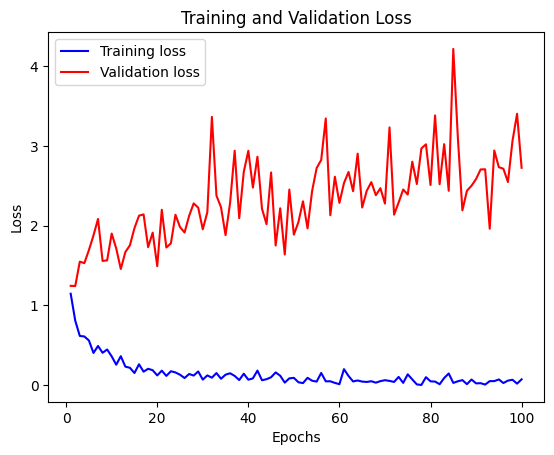

In [25]:
# Menampilkan grafik loss
loss = summary.history['loss']
val_loss = summary.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss.png'))
plt.show()

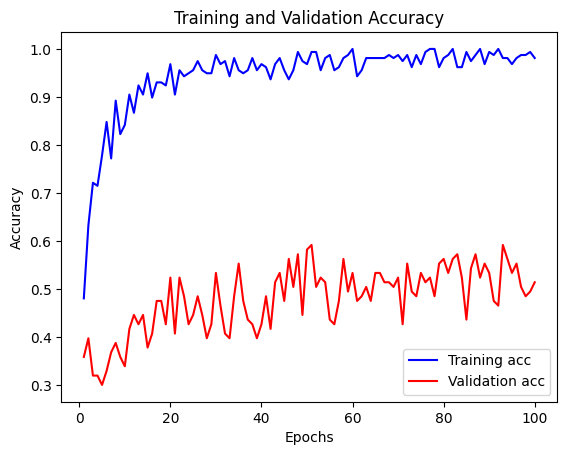

In [26]:
# Menampilkan grafik akurasi
acc = summary.history['accuracy']
val_acc = summary.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy.png'))
plt.show()